## Prepare Data

Prepare data for Train, Test, and Validation. Use them to try out different models.

In [56]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def get_rmse_score(model, X, y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
    rmse = np.sqrt(mse)
    return rmse

def get_train_rmse(model, X, y):
    model.fit(X, y)
    pred = model.predict(X)
    return mean_squared_error(y, pred)

import pandas as pd

seed = 42
df_train = pd.read_csv("data/train_clean.csv")

Y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)

print(f"Data Shapes:")
print(f"Train: {X_train.shape}")
print(f"Valid: {X_val.shape}")
print(f"Test:  {X_test.shape}")

Data Shapes:
Train: (1049, 280)
Valid: (117, 280)
Test:  (292, 280)


## Ridge and Lasso Linear Models

          RIDGE VS LASSO PERFORMANCE
----------------------------------------
Model  Train RMSE  Valid RMSE  Test RMSE
Ridge    0.089258    0.117072   0.122281
Lasso    0.092478    0.114743   0.120141


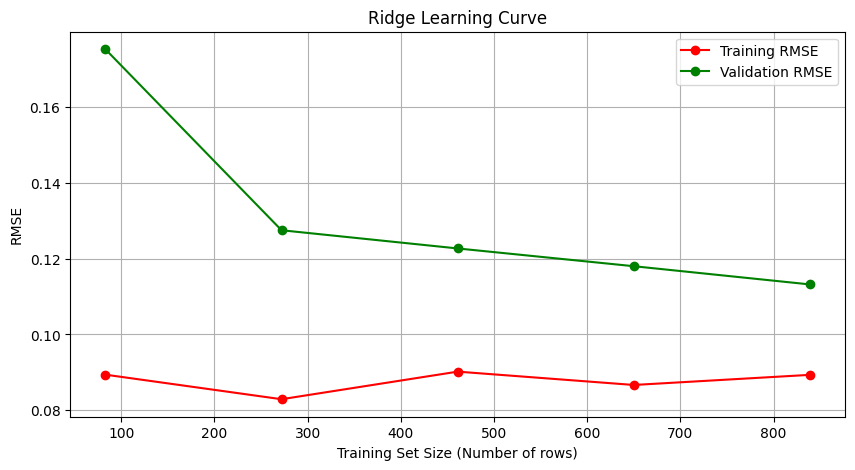

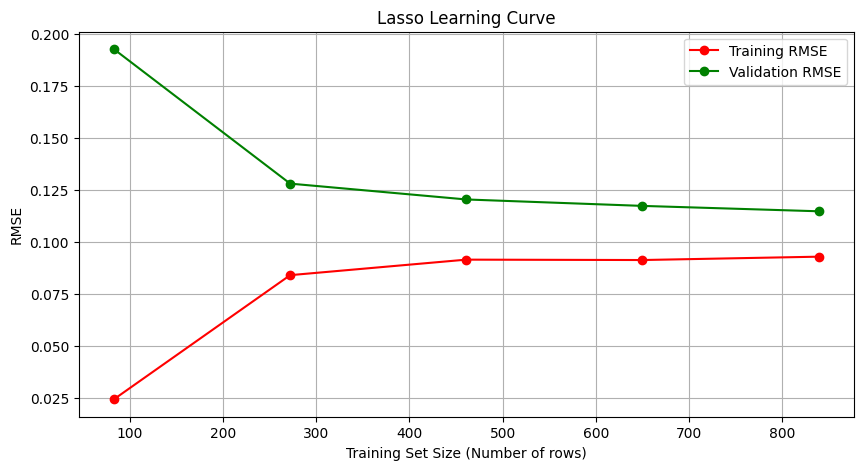

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

ridge_model = make_pipeline(
    RobustScaler(),
    RidgeCV(alphas=[0.1, 1, 5, 10, 20], cv=5)
)

lasso_model = make_pipeline(
    RobustScaler(),
    LassoCV(alphas=[0.0001, 0.0003, 0.0005, 0.001], cv=5, random_state=42)
)

ridge_model.fit(X_train, Y_train)
lasso_model.fit(X_train, Y_train)

def get_metrics(model, name):
    rmse_train = np.sqrt(mean_squared_error(Y_train, model.predict(X_train)))
    rmse_val   = np.sqrt(mean_squared_error(Y_val, model.predict(X_val)))
    rmse_test  = np.sqrt(mean_squared_error(Y_test, model.predict(X_test)))
    return [name, rmse_train, rmse_val, rmse_test]

results = []
results.append(get_metrics(ridge_model, "Ridge"))
results.append(get_metrics(lasso_model, "Lasso"))

df_results = pd.DataFrame(results, columns=["Model", "Train RMSE", "Valid RMSE", "Test RMSE"])
print("          RIDGE VS LASSO PERFORMANCE")
print("-"*40)
print(df_results.to_string(index=False))

def plot_sklearn_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, random_state=42
    )

    train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
    val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))

    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, val_rmse_mean, 'o-', color="g", label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training Set Size (Number of rows)")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Plot Curves
plot_sklearn_learning_curve(ridge_model, X_train, Y_train, "Ridge Learning Curve")
plot_sklearn_learning_curve(lasso_model, X_train, Y_train, "Lasso Learning Curve")

## XGBoost (Without and With Regularization)

XGBoost without any Regularization
 Dataset         RMSE
 Training    0.004651
Validation   0.146810
     Test    0.147750


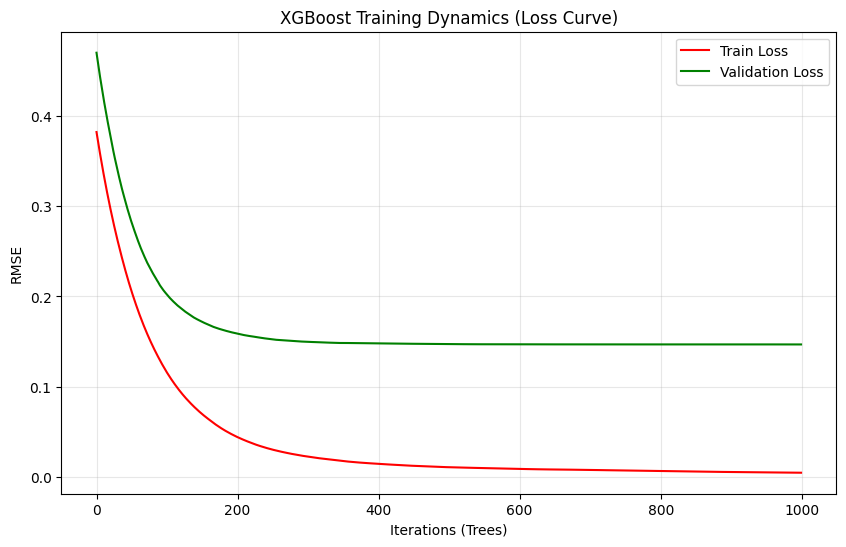

In [58]:
import matplotlib.pyplot as plt

xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.015, 
    max_depth=8, 
    n_jobs=-1,
    random_state=seed,
)

xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=False
)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

pred_train = xgb_model.predict(X_train)
pred_val   = xgb_model.predict(X_val)
pred_test  = xgb_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset    ': ['Training   ', 'Validation  ', 'Test   '],
    'RMSE': [rmse_train, rmse_val, rmse_test],
})

print("XGBoost without any Regularization")
print("="*40)
print(results_df.to_string(index=False))

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Loss', color='red')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation Loss', color='green')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations (Trees)')
plt.title('XGBoost Training Dynamics (Loss Curve)')
plt.grid(True, alpha=0.3)
plt.show()

XGBoost with Regularization
 Dataset         RMSE
 Training    0.039861
Validation   0.122677
     Test    0.119591


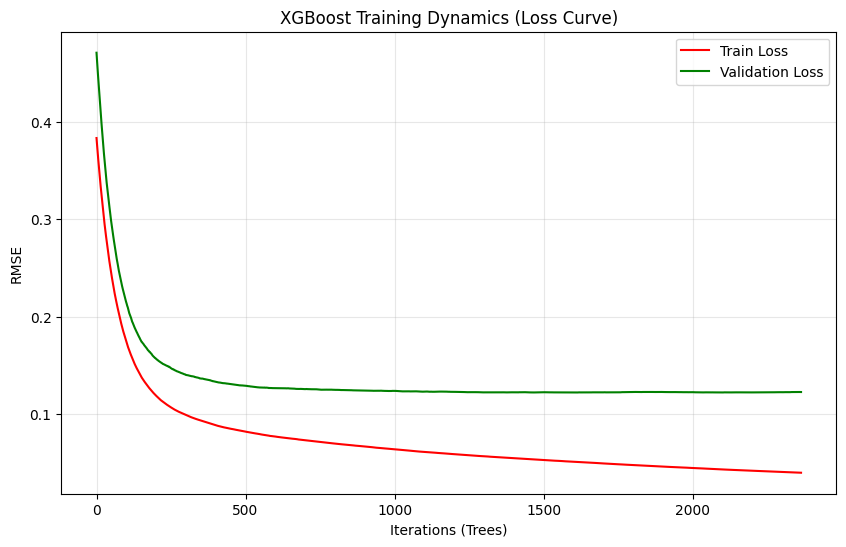

In [59]:
import matplotlib.pyplot as plt

xgb_model = XGBRegressor(
    n_estimators=2365, 
    learning_rate=0.015, 
    max_depth=3, 
    n_jobs=-1,
    random_state=seed,
    reg_alpha=0.02,         # L1 (Lasso): encourages sparsity (ignoring useless features)
    reg_lambda=3e-05,       # L2 (Ridge): discourages large weights (default is 1.0)
    subsample=0.6,          # Use only 80% of rows for each tree
    colsample_bytree=0.7,   # Use only 80% of features for each tree
)

xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=False
)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

pred_train = xgb_model.predict(X_train)
pred_val   = xgb_model.predict(X_val)
pred_test  = xgb_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset    ': ['Training   ', 'Validation  ', 'Test   '],
    'RMSE': [rmse_train, rmse_val, rmse_test],
})

print("XGBoost with Regularization")
print("="*30)
print(results_df.to_string(index=False))

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Loss', color='red')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation Loss', color='green')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations (Trees)')
plt.title('XGBoost Training Dynamics (Loss Curve)')
plt.grid(True, alpha=0.3)
plt.show()

## Support Vector Machine

SVR PERFORMANCE
------------------------------
      Dataset        RMSE
     Training    0.129715
   Validation    0.164933
Test (Unseen)    0.194318


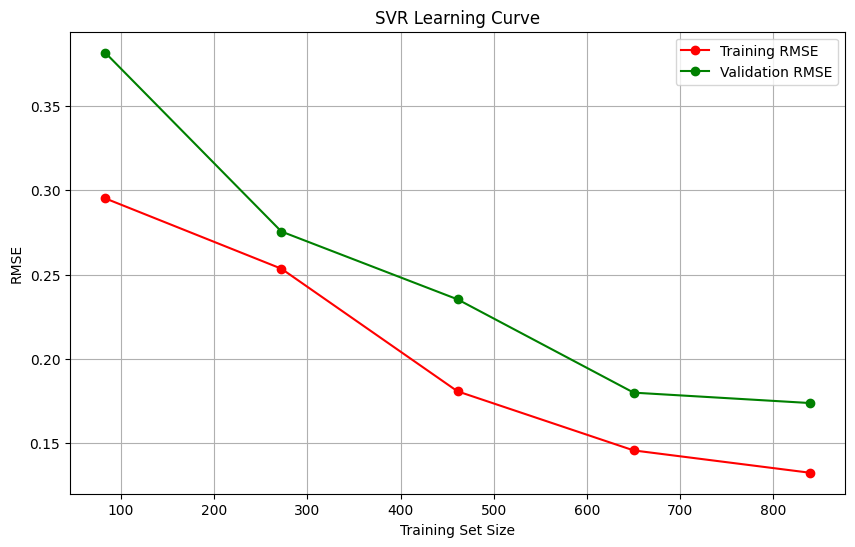

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

svr_model = make_pipeline(
    RobustScaler(),
    SVR(C=100, epsilon=0.01, gamma='scale', kernel='rbf')
)
svr_model.fit(X_train, Y_train)

pred_train = svr_model.predict(X_train)
pred_val   = svr_model.predict(X_val)
pred_test  = svr_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset   ': ['Training   ', 'Validation   ', 'Test (Unseen)   '],
    'RMSE': [rmse_train, rmse_val, rmse_test]
})

print("SVR PERFORMANCE")
print("-"*30)
print(results_df.to_string(index=False))

def plot_svr_learning_curve(estimator, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, 
        scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5), 
        n_jobs=-1, 
        random_state=42
    )

    train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
    val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, val_rmse_mean, 'o-', color="g", label="Validation RMSE")
    plt.title("SVR Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_svr_learning_curve(svr_model, X_train, Y_train)

## Neural Nets

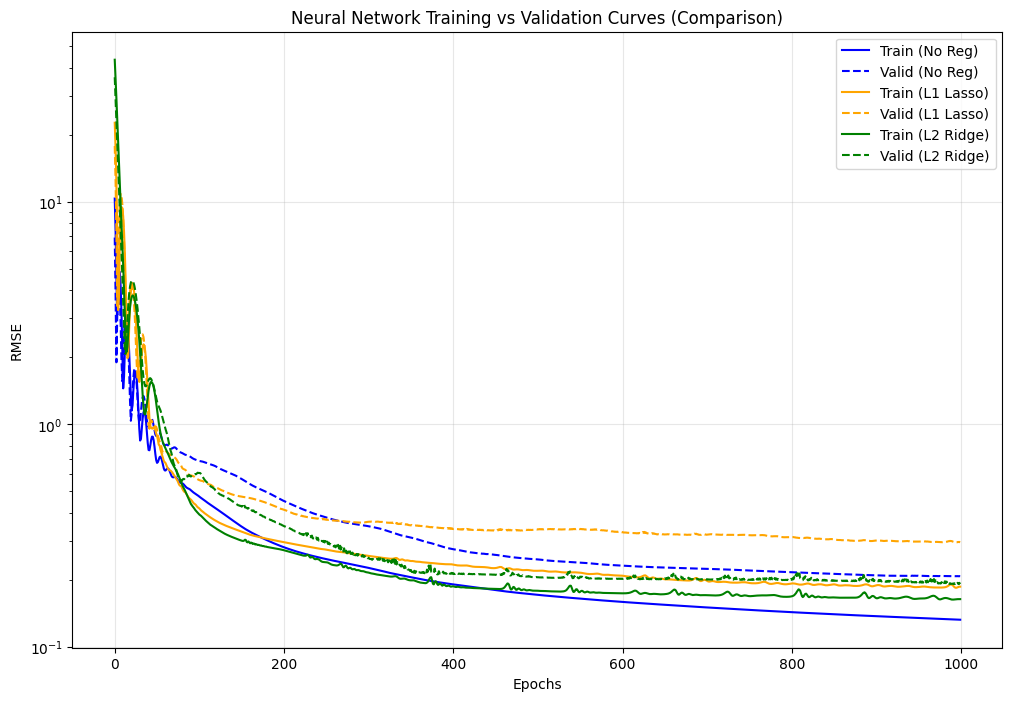


NEURAL NETWORK PERFORMANCE SUMMARY
--------------------------------------------------
           Method  Train RMSE  Valid RMSE  Test RMSE
No Regularization      0.1322      0.2074     0.1819
       L1 (Lasso)      0.1859      0.2948     0.2649
       L2 (Ridge)      0.1636      0.1913     0.2555
--------------------------------------------------


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')

X_train_t = torch.FloatTensor(X_train.values)
y_train_t = torch.FloatTensor(Y_train.values).view(-1, 1)

X_val_t   = torch.FloatTensor(X_val.values)
y_val_t   = torch.FloatTensor(Y_val.values).view(-1, 1)

X_test_t  = torch.FloatTensor(X_test.values)
y_test_t  = torch.FloatTensor(Y_test.values).view(-1, 1)

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32,32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

def train_model(reg_type='none', reg_strength=0.0, epochs=500, lr=0.01):
    model = Model(X_train_t.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        predictions = model(X_train_t)
        base_loss = criterion(predictions, y_train_t)

        reg_loss = 0
        if reg_type == 'l1':
            for param in model.parameters():
                reg_loss += torch.sum(torch.abs(param))
        elif reg_type == 'l2':
            for param in model.parameters():
                reg_loss += torch.sum(param ** 2)
        
        total_loss = base_loss + (reg_strength * reg_loss)
        total_loss.backward()
        optimizer.step()

        train_rmse = torch.sqrt(base_loss).item()
        train_loss_history.append(train_rmse)

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_rmse = torch.sqrt(criterion(val_pred, y_val_t)).item()
            val_loss_history.append(val_rmse)

    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_t)
        test_pred = model(X_test_t)
        
        final_train_rmse = np.sqrt(mean_squared_error(y_train_t, train_pred))
        final_val_rmse = val_loss_history[-1]
        final_test_rmse = np.sqrt(mean_squared_error(y_test_t, test_pred))
        
    return train_loss_history, val_loss_history, final_train_rmse, final_val_rmse, final_test_rmse

epochs = 1000
lr = 0.001
lambda_reg = 0.01

t_hist_none, v_hist_none, train_none, val_none, test_none = train_model(
    reg_type='none', reg_strength=lambda_reg, epochs=epochs, lr=lr
)
t_hist_l1, v_hist_l1, train_l1, val_l1, test_l1 = train_model(
    reg_type='l1', reg_strength=lambda_reg, epochs=epochs, lr=lr
)
t_hist_l2, v_hist_l2, train_l2, val_l2, test_l2 = train_model(
    reg_type='l2', reg_strength=lambda_reg, epochs=epochs, lr=lr
)

plt.figure(figsize=(12, 8))

plt.plot(t_hist_none, label='Train (No Reg)', color='blue')
plt.plot(v_hist_none, label='Valid (No Reg)', color='blue', linestyle='--')

plt.plot(t_hist_l1, label='Train (L1 Lasso)', color='orange')
plt.plot(v_hist_l1, label='Valid (L1 Lasso)', color='orange', linestyle='--')

plt.plot(t_hist_l2, label='Train (L2 Ridge)', color='green')
plt.plot(v_hist_l2, label='Valid (L2 Ridge)', color='green', linestyle='--')

plt.yscale('log')
plt.title('Neural Network Training vs Validation Curves (Comparison)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

results_df = pd.DataFrame({
    'Method': ['No Regularization', 'L1 (Lasso)', 'L2 (Ridge)'],
    'Train RMSE': [train_none, train_l1, train_l2],
    'Valid RMSE': [val_none, val_l1, val_l2],
    'Test RMSE':  [test_none, test_l1, test_l2]
})

print("\nNEURAL NETWORK PERFORMANCE SUMMARY")
print("-" * 50)
print(results_df.round(4).to_string(index=False))
print("-" * 50)

In [62]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_squared_error',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    # Convert negative MSE to RMSE
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Error")
    
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("RMSE (Log Scale)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

Best Alpha: 0.00033


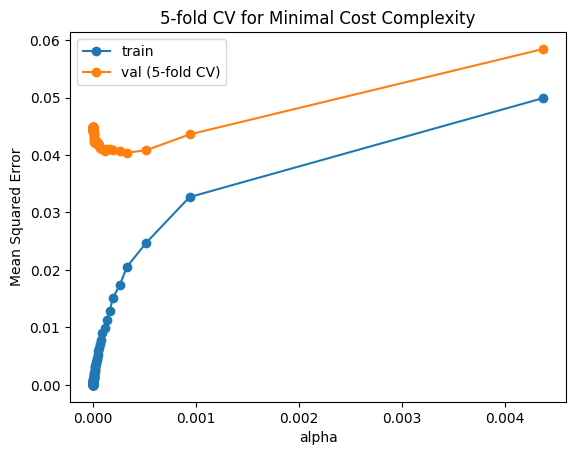

Best Max Depth: 5.00


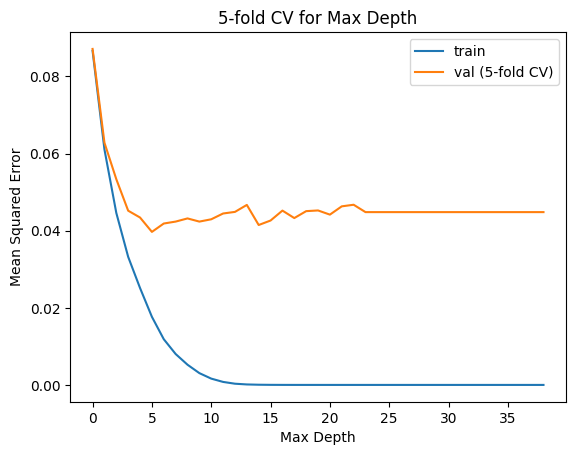

In [63]:
# Decision Tree Validation
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# init decission tree classifier
tree = DecisionTreeRegressor(criterion="squared_error")

# use Minimal Cost Complexity for pruning
path = tree.cost_complexity_pruning_path(X_train,Y_train)
ccp_alphas = path.ccp_alphas

# Use 5-fold cross validation to evaluate performance based on ccp_alpha
mean_train_scores = []
mean_val_scores = []
# evaluate every 10th alpha for time purposes
for ccp_alpha in ccp_alphas[::10]:  
    tree = DecisionTreeRegressor(random_state=seed, ccp_alpha=ccp_alpha)
    
    cv_scores = -cross_val_score(tree, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    mean_val_scores.append(cv_scores.mean())
    
    tree.fit(X_train, Y_train)
    Y_pred = tree.predict(X_train)
    mse = mean_squared_error(Y_train,Y_pred)
    mean_train_scores.append(mse)

best_index = np.argmin(mean_val_scores)
best_alpha = ccp_alphas[::10][best_index]
print("Best Alpha: %.5f" % (best_alpha))

# graph shows a small increase in accuracy w/ a very small alpha
# we will find that this does not have a very large impact on final performance
plt.title("5-fold CV for Minimal Cost Complexity")
plt.plot(ccp_alphas[::10], mean_train_scores, label='train', marker='o')
plt.plot(ccp_alphas[::10], mean_val_scores, label='val (5-fold CV)',marker='o')
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


# 5-fold cross validation for max depth
mean_train_scores = []
mean_val_scores = []
for max_depth in range(1,40):
    tree = DecisionTreeRegressor(random_state=seed,max_depth=max_depth)
    
    cv_scores = -cross_val_score(tree, X_train, Y_train, cv=5, scoring="neg_mean_squared_error")
    mean_val_scores.append(cv_scores.mean())

    tree.fit(X_train, Y_train)
    Y_pred = tree.predict(X_train)
    mse = mean_squared_error(Y_train,Y_pred)
    mean_train_scores.append(mse)

best_max_depth = np.argmin(mean_val_scores)
print("Best Max Depth: %.2f" % (best_max_depth))

# chart shows that we achieve about the best result with a tree with a depth of just 5
plt.title("5-fold CV for Max Depth")
plt.plot(mean_train_scores, label='train')
plt.plot(mean_val_scores, label='val (5-fold CV)')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


Training Score: 0.71
Train Mean Squared Error: 0.03
Test Score: 0.71
Test Mean Squared Error: 0.05
Most important features:
OverallQual          0.656566
Log_GrLivArea        0.130870
TotalBsmtSF          0.068730
CentralAir_Y         0.051838
GarageCars           0.018805
KitchenAbvGr         0.012339
MasVnrArea           0.011917
GarageType_Detchd    0.010458
BsmtFinSF1           0.007557
OverallCond          0.007526
dtype: float64


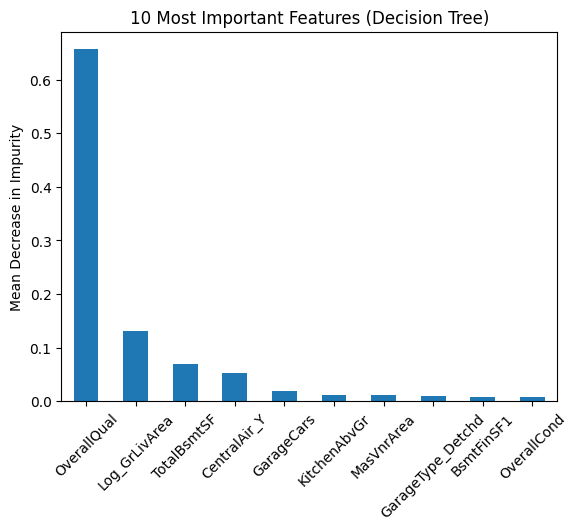

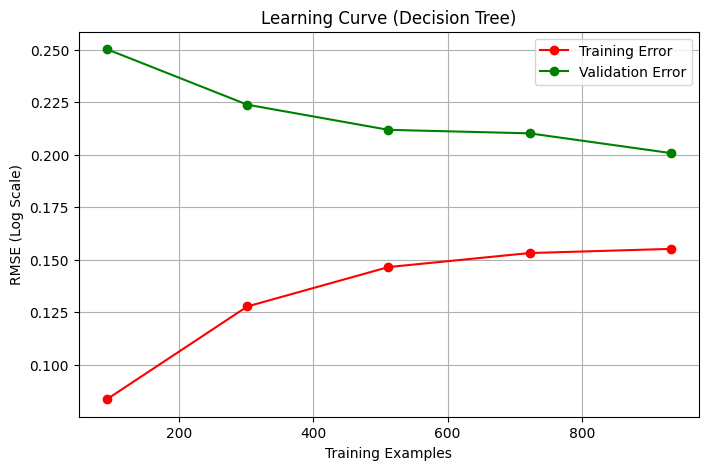

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split

# init decission tree classifier
final_tree = DecisionTreeRegressor(criterion="squared_error", ccp_alpha=best_alpha, max_depth=best_max_depth)

final_tree.fit(X_train, Y_train)

# In-sample error
Y_pred = final_tree.predict(X_train)

train_score = final_tree.score(X_test, Y_test) 
print("Training Score: %.2f" % (train_score))

mse = mean_squared_error(Y_train, Y_pred)
print("Train Mean Squared Error: %.2f" % (mse))

# Out-of-sample error
Y_pred = final_tree.predict(X_test)

test_score = final_tree.score(X_test, Y_test)
print("Test Score: %.2f" % (test_score))

mse = mean_squared_error(Y_test, Y_pred)
print("Test Mean Squared Error: %.2f" % (mse))

# List most important features 
# Will find that OverallQual is overwhelmingly important compared to other features
feature_importances = final_tree.feature_importances_
df_importances = pd.Series(feature_importances, index=X.columns)
important_features = df_importances.sort_values(ascending=False)[:10]
print("Most important features:")
print(important_features)

ax = important_features.plot(kind="bar", title="10 Most Important Features (Decision Tree)", rot=45)
ax.set_ylabel("Mean Decrease in Impurity")

plot_learning_curve(final_tree, "Learning Curve (Decision Tree)", X_train, Y_train)


Best n_estimators: 90.00


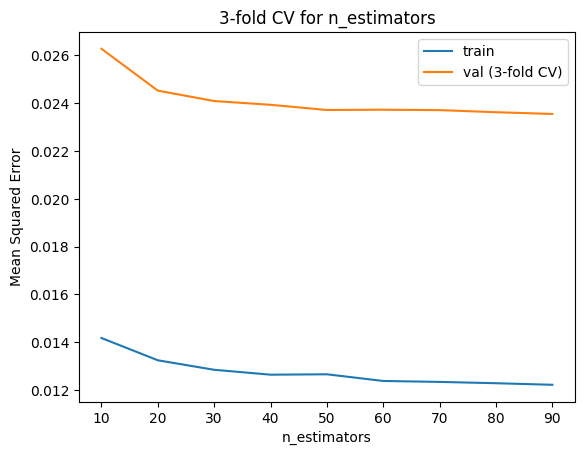

Train Score:  1
Train Mean Squared Error: 0.02
Test Score: 0.85
Test Mean Squared Error: 0.05
OverallQual      0.622281
Log_GrLivArea    0.131663
TotalBsmtSF      0.068327
GarageCars       0.056886
CentralAir_Y     0.017939
BsmtFinSF1       0.017587
YearBuilt        0.011860
Log_LotArea      0.007966
OverallCond      0.005401
YearRemodAdd     0.004634
dtype: float64


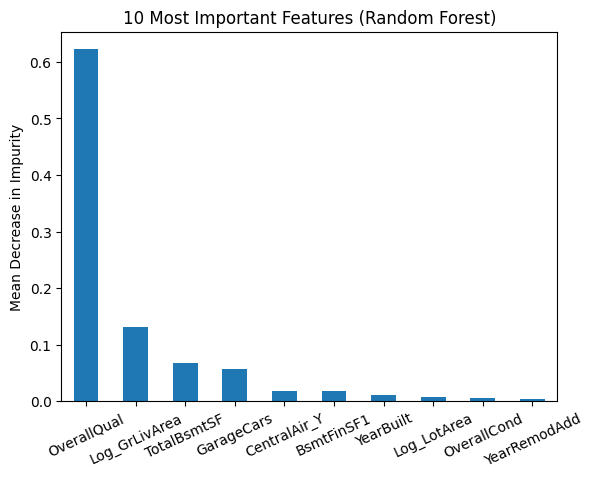

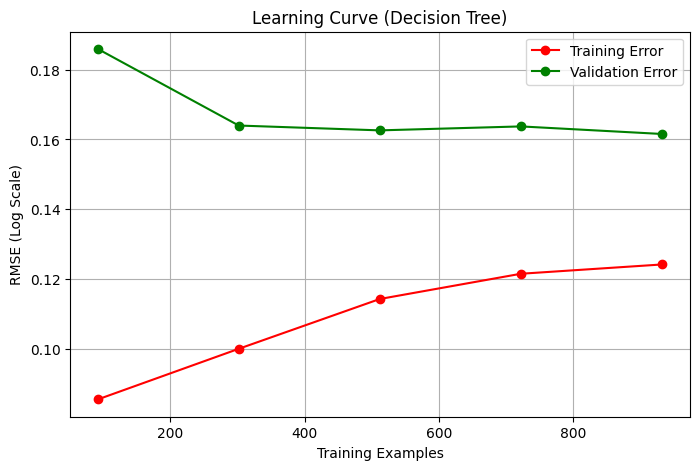

In [65]:
# Random Forest 
from sklearn.ensemble import RandomForestRegressor

# 3-fold cross validation to determine ideal n_estimators
mean_train_scores = []
mean_val_scores = []
estimator_range = range(10,100,10)
for estimators in estimator_range:
    forest = RandomForestRegressor(random_state=seed,ccp_alpha=best_alpha,max_depth=max_depth,n_estimators=estimators)
    
    cv_scores = -cross_val_score(forest, X_train, Y_train, cv=3, scoring="neg_mean_squared_error")
    mean_val_scores.append(cv_scores.mean())

    forest.fit(X_train, Y_train)
    Y_pred = forest.predict(X_train)
    mse = mean_squared_error(Y_train,Y_pred)
    mean_train_scores.append(mse)

best_index = np.argmin(mean_val_scores)
best_n_estimators = estimator_range[best_index]
print("Best n_estimators: %.2f" % (best_n_estimators))

# Find that there is only marginal imporovements to performance as n_estimators increases
plt.title("3-fold CV for n_estimators")
plt.plot(estimator_range, mean_train_scores, label='train')
plt.plot(estimator_range, mean_val_scores, label='val (3-fold CV)')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

final_forest = RandomForestRegressor(n_estimators=best_n_estimators, random_state=seed, ccp_alpha=best_alpha, max_depth=best_max_depth)

final_forest.fit(X_train,Y_train)

# In-sample error
Y_pred = final_forest.predict(X_train)

train_score = final_forest.score(X_train,Y_train)
print("Train Score: %2.f" % (train_score))

mse = mean_squared_error(Y_train,Y_pred)
print("Train Mean Squared Error: %.2f" % (mse))

# Out-of-sample error
Y_pred = final_tree.predict(X_test)

test_score = final_forest.score(X_test,Y_test)
print("Test Score: %.2f" % (test_score))

mse = mean_squared_error(Y_test,Y_pred)
print("Test Mean Squared Error: %.2f" % (mse))

# List most important features
feature_importances = final_forest.feature_importances_
df_importances = pd.Series(feature_importances, index=X.columns)
important_features = df_importances.sort_values(ascending=False)[:10]
print(important_features)

ax = important_features.plot(kind="bar", title="10 Most Important Features (Random Forest)", rot=25)
ax.set_ylabel("Mean Decrease in Impurity")

plot_learning_curve(final_forest, "Learning Curve (Decision Tree)", X_train, Y_train)